In [1]:
# EDA
import pandas as pd
import numpy as np

# oracle sql
import cx_Oracle

## date handling
from datetime import datetime, timedelta
from pytz import timezone


# visualizing
import seaborn as sns
import matplotlib.pyplot as plt

# modelling
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor

# accuracy metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# scaling
from sklearn.preprocessing import StandardScaler

# deployment
import pickle as pkl
from sklearn.pipeline import Pipeline

## for ignoring deprecation warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
dsn = cx_Oracle.makedsn("dwh-scan.kapitalbank.az", 1521, service_name="report")

connection = cx_Oracle.connect(user='SAMADOVIAZ_15121[FRAUD]',password='Dwh*@(#062326:53B1CD62470',dsn=dsn)

In [14]:
query_all="""
select /*+parallel */
 a.bank_time,
 a.TERMOWNER,
 round(a.CASHBACK_RATE, 1) CASHBACK_RATE,
 round(a.CASHBACK_AMOUNT, 1) CASHBACK_AMOUNT,
 round(a.BALANCE_AFTER, 1) BALANCE_AFTER,
 a.DIRECTION,
 b.pin,
 b.marstat,
 b.birth_date,
 b.hiredate,
 c.mcc,
 c.mcc_description,
 c.mcc_group,
 d.id,
 d.currency,
 d.name
  from cms.f_cashback_transaction a
 inner join fraud.emp_01_05_2023 b
    on a.cms_id = b.cms_id
 INNER JOIN CMS.D_MCC_DETAILS C
    ON A.MCC = C.MCC
 inner join dwh.D_CURRENCY d
    on a.from_cur = d.id"""

In [15]:
%%time

df_all=pd.read_sql(query_all,con=connection)
df_all.tail()

Wall time: 1min 29s


,BANK_TIME,TERMOWNER,CASHBACK_RATE,CASHBACK_AMOUNT,BALANCE_AFTER,DIRECTION,PIN,MARSTAT,BIRTH_DATE,HIREDATE,MCC,MCC_DESCRIPTION,MCC_GROUP,ID,CURRENCY,NAME
2187137,2021-09-16 19:15:03,POS LINS COFFEE S.R,1.5,0.1,0.3,CREDIT,2HQBLXN,Evli,25.06.1967,17.10.2019,5812,"Eating Places, Restaurants",VARIOUS SHOPS,944,AZN,Азербайджанский манат
2187138,2021-09-16 17:43:03,SPECIALTY COFFEE,1.5,0.1,0.3,CREDIT,2HQBLXN,Evli,25.06.1967,17.10.2019,5499,"Misc Food Stores-Speciality,Convenience,",RETAIL STORES,944,AZN,Азербайджанский манат
2187139,2021-09-16 11:49:07,PASHA POS H2H MCD 28 MAY 6,1.5,0.0,0.0,CREDIT,2HQBLXN,Evli,25.06.1967,17.10.2019,5814,Fast Food Resturant,VARIOUS SHOPS,944,AZN,Азербайджанский манат
2187140,2021-09-16 11:51:28,BRAVO MARKET 28 MALL,1.5,0.0,0.1,CREDIT,2HQBLXN,Evli,25.06.1967,17.10.2019,5411,"Grocery Stores, Supermarkets",RETAIL STORES,944,AZN,Азербайджанский манат
2187141,2023-04-26 22:54:29,L?MON SUPERMARKET,1.5,0.2,2.5,CREDIT,2HQBLXN,Evli,25.06.1967,17.10.2019,5411,"Grocery Stores, Supermarkets",RETAIL STORES,944,AZN,Азербайджанский манат


In [16]:
df_all.to_parquet(r"df.parquet")

In [11]:
df_all=pd.read_parquet('df.parquet')
df_all

,BANK_TIME,TERMOWNER,CASHBACK_RATE,CASHBACK_AMOUNT,BALANCE_AFTER,DIRECTION,PIN,MARSTAT,BIRTH_DATE,HIREDATE,MCC,MCC_DESCRIPTION,MCC_GROUP,ID,CURRENCY,NAME
0,2022-12-19 18:31:21,AL MARKET XATAI NASRA,3.0,0.3,50.3,CREDIT,6XXLEJG,Subay,21.01.2000,26.12.2022,5411,"Grocery Stores, Supermarkets",RETAIL STORES,944,AZN,Азербайджанский манат
1,2022-12-18 13:41:43,ZEYTUN APTEK 12,1.5,0.3,49.9,CREDIT,6XXLEJG,Subay,21.01.2000,26.12.2022,5912,"Drug Stores, Pharmacies",VARIOUS SHOPS,944,AZN,Азербайджанский манат
2,2022-12-18 13:38:05,BUTA FARM APTEK 324,1.5,0.7,49.6,CREDIT,6XXLEJG,Subay,21.01.2000,26.12.2022,5912,"Drug Stores, Pharmacies",VARIOUS SHOPS,944,AZN,Азербайджанский манат
3,2022-11-09 15:40:43,AL MARKET XATAI NASRA,3.0,0.0,35.5,CREDIT,6XXLEJG,Subay,21.01.2000,26.12.2022,5411,"Grocery Stores, Supermarkets",RETAIL STORES,944,AZN,Азербайджанский манат
4,2023-04-19 21:15:02,BUTA FARM APTEK 324,1.5,0.1,29.7,CREDIT,6XXLEJG,Subay,21.01.2000,26.12.2022,5912,"Drug Stores, Pharmacies",VARIOUS SHOPS,944,AZN,Азербайджанский манат
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187137,2021-09-16 19:15:03,POS LINS COFFEE S.R,1.5,0.1,0.3,CREDIT,2HQBLXN,Evli,25.06.1967,17.10.2019,5812,"Eating Places, Restaurants",VARIOUS SHOPS,944,AZN,Азербайджанский манат
2187138,2021-09-16 17:43:03,SPECIALTY COFFEE,1.5,0.1,0.3,CREDIT,2HQBLXN,Evli,25.06.1967,17.10.2019,5499,"Misc Food Stores-Speciality,Convenience,",RETAIL STORES,944,AZN,Азербайджанский манат
2187139,2021-09-16 11:49:07,PASHA POS H2H MCD 28 MAY 6,1.5,0.0,0.0,CREDIT,2HQBLXN,Evli,25.06.1967,17.10.2019,5814,Fast Food Resturant,VARIOUS SHOPS,944,AZN,Азербайджанский манат
2187140,2021-09-16 11:51:28,BRAVO MARKET 28 MALL,1.5,0.0,0.1,CREDIT,2HQBLXN,Evli,25.06.1967,17.10.2019,5411,"Grocery Stores, Supermarkets",RETAIL STORES,944,AZN,Азербайджанский манат


In [4]:
df_all.describe()

,CASHBACK_RATE,CASHBACK_AMOUNT,BALANCE_AFTER,ID
count,2.187136e+06,2.187142e+06,2.187142e+06,2.187142e+06
mean,1.427072e+00,3.159136e-01,1.622222e+01,9.202664e+02
std,1.356350e+00,2.408913e+00,5.204561e+01,4.366515e+01
min,0.000000e+00,0.000000e+00,-9.939000e+02,8.400000e+02
25%,5.000000e-01,0.000000e+00,1.100000e+00,9.440000e+02
50%,1.500000e+00,1.000000e-01,3.600000e+00,9.440000e+02
75%,2.000000e+00,2.000000e-01,1.220000e+01,9.440000e+02
max,4.000000e+01,5.000000e+02,2.333100e+03,9.780000e+02


In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2187142 entries, 0 to 2187141
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   BANK_TIME        datetime64[ns]
 1   TERMOWNER        object        
 2   CASHBACK_RATE    float64       
 3   CASHBACK_AMOUNT  float64       
 4   BALANCE_AFTER    float64       
 5   DIRECTION        object        
 6   PIN              object        
 7   MARSTAT          object        
 8   BIRTH_DATE       object        
 9   HIREDATE         object        
 10  MCC              object        
 11  MCC_DESCRIPTION  object        
 12  MCC_GROUP        object        
 13  ID               int64         
 14  CURRENCY         object        
 15  NAME             object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(11)
memory usage: 267.0+ MB


In [6]:
df_all.duplicated().sum()

619

In [7]:
df_all.isna().sum()

BANK_TIME              0
TERMOWNER            184
CASHBACK_RATE          6
CASHBACK_AMOUNT        0
BALANCE_AFTER          0
DIRECTION              0
PIN                    0
MARSTAT            11559
BIRTH_DATE          9550
HIREDATE               0
MCC                    0
MCC_DESCRIPTION        0
MCC_GROUP              0
ID                     0
CURRENCY               0
NAME                   0
dtype: int64

In [6]:
df_all.loc[df_all['BIRTH_DATE'].isna(),'PIN'].unique()

array(['2G6YY4S', '41SL261', '53J096K', '69V61VM', '6AWFSBZ', '6ASJEYW',
       '33Q2NRJ', '66C5MCC', '2VJQK1L', '69RDZ6Q', '2S90MKA', '6FGY79G',
       '6E3LSS1', '695RS9Z', '62SZ34W', '2EX05D2', '61ACKXS', '63BH03P',
       '136GML5', '60CFME6', '2HMSQWC', '7B0NXNB', '2NNJ13X', '1ACPJ8A',
       '1ALBH5B', '64VD1S7', '67C0RMU', '79M3S2S', '35TAZN2', '7BG1FM4',
       '5UF6ZCH', '2S01CBB', '5EKJR6D'], dtype=object)

In [12]:
columns_to_fill=['TERMOWNER','MARSTAT','BIRTH_DATE','CASHBACK_RATE']

for column in columns_to_fill:
    mode_value=df_all[column].mode().iloc[0]
    df_all[column].fillna(mode_value,inplace=True)

In [13]:
df_all.isna().sum()

BANK_TIME          0
TERMOWNER          0
CASHBACK_RATE      0
CASHBACK_AMOUNT    0
BALANCE_AFTER      0
DIRECTION          0
PIN                0
MARSTAT            0
BIRTH_DATE         0
HIREDATE           0
MCC                0
MCC_DESCRIPTION    0
MCC_GROUP          0
ID                 0
CURRENCY           0
NAME               0
dtype: int64

In [14]:
df_all = df_all.apply(lambda x: x.str.upper() if x.dtype == "object" else x) ## upper case all values

<AxesSubplot:xlabel='MARSTAT'>

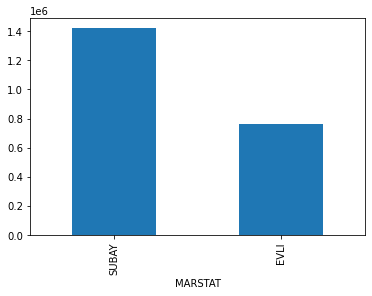

In [18]:
marstat=df_all['MARSTAT'].value_counts()
marstat.plot(kind='bar')

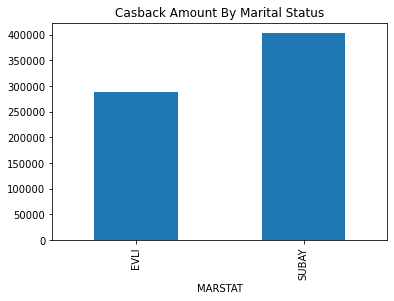

<Figure size 720x432 with 0 Axes>

In [26]:
sum_of_cb_amount_by_marstat=df_all.groupby('MARSTAT')['CASHBACK_AMOUNT'].sum()
plt.title('Casback Amount By Marital Status')
sum_of_cb_amount_by_marstat.plot(kind='bar')
plt.figure(figsize=(10,6))
plt.show()

In [33]:
df_all['BANK_TIME']=pd.to_datetime(df_all['BANK_TIME'],format='%d.%m.%Y')

In [38]:
df_all['hour']=df_all['BANK_TIME'].dt.hour
df_all['day']=df_all['BANK_TIME'].dt.day
df_all['weekday']=df_all['BANK_TIME'].dt.weekday+1
df_all['month']=df_all['BANK_TIME'].dt.month
df_all['year']=df_all['BANK_TIME'].dt.year
df_all['day_of_year']=df_all['BANK_TIME'].dt.day_of_year

In [39]:
df_all

,BANK_TIME,TERMOWNER,CASHBACK_RATE,CASHBACK_AMOUNT,BALANCE_AFTER,DIRECTION,PIN,MARSTAT,BIRTH_DATE,HIREDATE,...,MCC_GROUP,ID,CURRENCY,NAME,hour,day,weekday,month,year,day_of_year
0,2022-12-19 18:31:21,AL MARKET XATAI NASRA,3.0,0.3,50.3,CREDIT,6XXLEJG,SUBAY,21.01.2000,26.12.2022,...,RETAIL STORES,944,AZN,АЗЕРБАЙДЖАНСКИЙ МАНАТ,18,19,1,12,2022,353
1,2022-12-18 13:41:43,ZEYTUN APTEK 12,1.5,0.3,49.9,CREDIT,6XXLEJG,SUBAY,21.01.2000,26.12.2022,...,VARIOUS SHOPS,944,AZN,АЗЕРБАЙДЖАНСКИЙ МАНАТ,13,18,7,12,2022,352
2,2022-12-18 13:38:05,BUTA FARM APTEK 324,1.5,0.7,49.6,CREDIT,6XXLEJG,SUBAY,21.01.2000,26.12.2022,...,VARIOUS SHOPS,944,AZN,АЗЕРБАЙДЖАНСКИЙ МАНАТ,13,18,7,12,2022,352
3,2022-11-09 15:40:43,AL MARKET XATAI NASRA,3.0,0.0,35.5,CREDIT,6XXLEJG,SUBAY,21.01.2000,26.12.2022,...,RETAIL STORES,944,AZN,АЗЕРБАЙДЖАНСКИЙ МАНАТ,15,9,3,11,2022,313
4,2023-04-19 21:15:02,BUTA FARM APTEK 324,1.5,0.1,29.7,CREDIT,6XXLEJG,SUBAY,21.01.2000,26.12.2022,...,VARIOUS SHOPS,944,AZN,АЗЕРБАЙДЖАНСКИЙ МАНАТ,21,19,3,4,2023,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187137,2021-09-16 19:15:03,POS LINS COFFEE S.R,1.5,0.1,0.3,CREDIT,2HQBLXN,EVLI,25.06.1967,17.10.2019,...,VARIOUS SHOPS,944,AZN,АЗЕРБАЙДЖАНСКИЙ МАНАТ,19,16,4,9,2021,259
2187138,2021-09-16 17:43:03,SPECIALTY COFFEE,1.5,0.1,0.3,CREDIT,2HQBLXN,EVLI,25.06.1967,17.10.2019,...,RETAIL STORES,944,AZN,АЗЕРБАЙДЖАНСКИЙ МАНАТ,17,16,4,9,2021,259
2187139,2021-09-16 11:49:07,PASHA POS H2H MCD 28 MAY 6,1.5,0.0,0.0,CREDIT,2HQBLXN,EVLI,25.06.1967,17.10.2019,...,VARIOUS SHOPS,944,AZN,АЗЕРБАЙДЖАНСКИЙ МАНАТ,11,16,4,9,2021,259
2187140,2021-09-16 11:51:28,BRAVO MARKET 28 MALL,1.5,0.0,0.1,CREDIT,2HQBLXN,EVLI,25.06.1967,17.10.2019,...,RETAIL STORES,944,AZN,АЗЕРБАЙДЖАНСКИЙ МАНАТ,11,16,4,9,2021,259


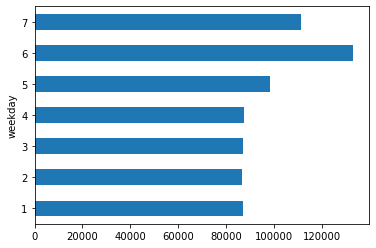

In [54]:
df_all.groupby('weekday')['CASHBACK_AMOUNT'].sum().plot(kind='barh')

plt.show()

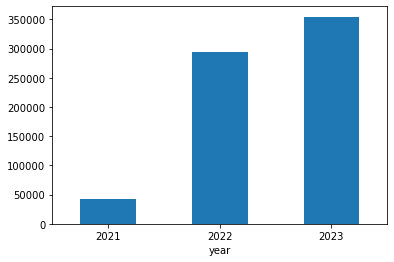

In [77]:
df_all.groupby('year')['CASHBACK_AMOUNT'].sum().sort_values(ascending=True).plot(kind='bar')
plt.xticks(rotation=360)
plt.show()